# TransactionHistory
Predicting ActualCost

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from torch.utils.data import TensorDataset, DataLoader
from common_functions import drop_sk_datetime_added_columns as drop_columns, train_model, get_engine, \
    read_data_return_df, plot_predictions, plot_feature_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import torch

## Connecting to the database

In [2]:
engine = get_engine()

Connection to UnitedOutdoors database successful


## Reading the data

In [3]:
transactionhistory_sql_query = "SELECT * FROM TransactionHistory"
transactionhistory_df = read_data_return_df(transactionhistory_sql_query, engine)

transactionhistory_df.head()

,TRANSACTIONHISTORY_sk,TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionID,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ProductID,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ReferenceOrderID,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ReferenceOrderLineID,TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionDate,TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionType,TRANSACTIONHISTORY_TRANSACTIONHISTORY_Quantity,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ActualCost,TRANSACTIONHISTORY_datetime_added
0,1,100000,684,41590,0,2013-07-31,W,2,0.0,2024-05-25 08:08:00.377
1,2,100001,744,41591,0,2013-07-31,W,1,0.0,2024-05-25 08:08:00.377
2,3,100002,762,41592,0,2013-07-31,W,1,0.0,2024-05-25 08:08:00.377
3,4,100003,768,41593,0,2013-07-31,W,1,0.0,2024-05-25 08:08:00.377
4,5,100004,774,41594,0,2013-07-31,W,1,0.0,2024-05-25 08:08:00.377


In [4]:
product_sql_query = "SELECT * FROM Product"
product_df = read_data_return_df(product_sql_query, engine)

product_df.head()

,PRODUCT_sk,PRODUCT_PRODUCT_ID,PRODUCT_UNITMEASURE_SIZE_ID,PRODUCT_UNITMEASURE_WEIGHT_ID,PRODUCT_PRODUCT_SubCategoryID,PRODUCT_PRODUCTSUBCATEGORY_CategoryID,PRODUCT_PRODUCT_ModelID,PRODUCT_PRODUCTMODELILLUSTRATION_IllustrationID,PRODUCT_PRODUCTPRODUCTPHOTO_PhotoID,PRODUCT_PMPDC_DescriptionID,...,PRODUCT_PRODUCTPHOTO_LargePhotoHexString,PRODUCT_PRODUCTPHOTO_LargePhotoFileName,PRODUCT_PRODUCT_SellStartDate,PRODUCT_DATE_SellStartDateFK,PRODUCT_PRODUCT_SellEndDate,PRODUCT_DATE_SellEndDateFK,PRODUCT_PRODUCT_DiscountedDate,PRODUCT_DATE_DiscountedDateFK,PRODUCT_PRODUCT_Discontinued,PRODUCT_datetime_added
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-25 08:05:28.007
1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-25 08:05:28.007
2,3,3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-25 08:05:28.007
3,4,4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-25 08:05:28.007
4,5,316,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-25 08:05:28.007


## Data cleaning

In [5]:
# combining the two dataframes
combined_df = pd.merge(transactionhistory_df, product_df, left_on='TRANSACTIONHISTORY_TRANSACTIONHISTORY_ProductID', right_on='PRODUCT_sk')

# dropping all rows where 

# dropping the datetime_added and sk columns. Also handling the null values
drop_columns(combined_df)

In [6]:
columns_to_drop = ['PRODUCT_UNITMEASURE_SIZE_ID', 'PRODUCT_UNITMEASURE_WEIGHT_ID', 'PRODUCT_PRODUCTPRODUCTPHOTO_PhotoID', 'PRODUCT_PMPDC_DescriptionID', 'PRODUCT_PRODUCT_Name', 'PRODUCT_PRODUCT_Number', 'PRODUCT_PRODUCT_MakeFlag', 'PRODUCT_PRODUCT_FinishedGoodsFlag', 'PRODUCT_PRODUCT_Color', 'PRODUCT_PRODUCTSUBCATEGORY_SubCategory', 'PRODUCT_PRODUCTCATEGORY_Category', 'PRODUCT_PRODUCTMODEL_Name', 'PRODUCT_PRODUCTMODEL_CatalogDescription', 'PRODUCT_PRODUCTMODEL_Instructions', 'PRODUCT_ILLUSTRATION_Diagram', 'PRODUCT_CULTURE_Name', 'PRODUCT_PRODUCTDESCRIPTION_Desc', 'PRODUCT_PRODUCTPRODUCTPHOTO_Primary', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhoto', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhotoHexString', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhotoFileName', 'PRODUCT_PRODUCTPHOTO_LargePhoto', 'PRODUCT_PRODUCTPHOTO_LargePhotoHexString', 'PRODUCT_PRODUCTPHOTO_LargePhotoFileName', 'PRODUCT_PRODUCT_SellStartDate', 'PRODUCT_PRODUCT_SellEndDate',  'PRODUCT_PRODUCT_StandardCost', 'PRODUCT_PRODUCTMODELILLUSTRATION_IllustrationID', 'PRODUCT_PRODUCT_SafetyStockLevel', 'PRODUCT_PRODUCT_ReorderPoint', 'PRODUCT_PRODUCT_ListPrice', 'PRODUCT_CATEGORY_Picture', 'PRODUCT_PRODUCT_Discontinued', 'PRODUCT_PRODUCT_QuantityPerUnit', 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionID', 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_ProductID', 'TRANSACTIONHISTORY_TRANSACTIONHISTORY_ReferenceOrderID']

combined_df.drop(columns=columns_to_drop, inplace=True)

In [7]:
combined_df['TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionDate'] = combined_df['TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionDate'].astype(str).str.replace('-', '').astype(int)

combined_df['TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionType'] = combined_df['TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionType'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_SubCategoryID'] = combined_df['PRODUCT_PRODUCT_SubCategoryID'].astype('category').cat.codes
combined_df['PRODUCT_PMPDC_CultureID'] = combined_df['PRODUCT_PMPDC_CultureID'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_ProductLine'] = combined_df['PRODUCT_PRODUCT_ProductLine'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Size'] = combined_df['PRODUCT_PRODUCT_Size'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Class'] = combined_df['PRODUCT_PRODUCT_Class'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Style'] = combined_df['PRODUCT_PRODUCT_Style'].astype('category').cat.codes

In [8]:
combined_df.head()

,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ReferenceOrderLineID,TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionDate,TRANSACTIONHISTORY_TRANSACTIONHISTORY_TransactionType,TRANSACTIONHISTORY_TRANSACTIONHISTORY_Quantity,TRANSACTIONHISTORY_TRANSACTIONHISTORY_ActualCost,PRODUCT_PRODUCT_ID,PRODUCT_PRODUCT_SubCategoryID,PRODUCT_PRODUCTSUBCATEGORY_CategoryID,PRODUCT_PRODUCT_ModelID,PRODUCT_PMPDC_CultureID,...,PRODUCT_PRODUCT_UnitsOnOrder,PRODUCT_PRODUCT_Size,PRODUCT_PRODUCT_Weight,PRODUCT_PRODUCT_DaysToManufacture,PRODUCT_PRODUCT_ProductLine,PRODUCT_PRODUCT_Class,PRODUCT_PRODUCT_Style,PRODUCT_DATE_SellStartDateFK,PRODUCT_DATE_SellEndDateFK,PRODUCT_DATE_DiscountedDateFK
0,0,20130731,2,2,0.0,784,1,1.0,20.0,2,...,-1.0,5,24.13,4.0,1,1,2,20120530,18000101,18000101
1,0,20130731,2,1,0.0,794,2,1.0,26.0,2,...,-1.0,6,15.13,4.0,2,1,2,20120530,18000101,18000101
2,0,20130731,2,1,0.0,797,2,1.0,29.0,2,...,-1.0,1,17.35,4.0,2,3,3,20120530,18000101,18000101
3,0,20130731,2,1,0.0,798,2,1.0,29.0,2,...,-1.0,2,17.77,4.0,2,3,3,20120530,18000101,18000101
4,0,20130731,2,1,0.0,799,2,1.0,29.0,2,...,-1.0,3,18.13,4.0,2,3,3,20120530,18000101,18000101


## Data preprocessing

### Splitting the data

In [9]:
# splitting the data
X = combined_df.drop(columns=['TRANSACTIONHISTORY_TRANSACTIONHISTORY_ActualCost'])
y = combined_df['TRANSACTIONHISTORY_TRANSACTIONHISTORY_ActualCost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training

### Linear Regression

In [10]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# fitting the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [12]:
# predicting the values
lr_y_pred = lr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the data

In [13]:
# calculating the metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R2 Score: {lr_r2}')

Mean Squared Error: 134156.52576778934
R2 Score: 0.5658680846304551


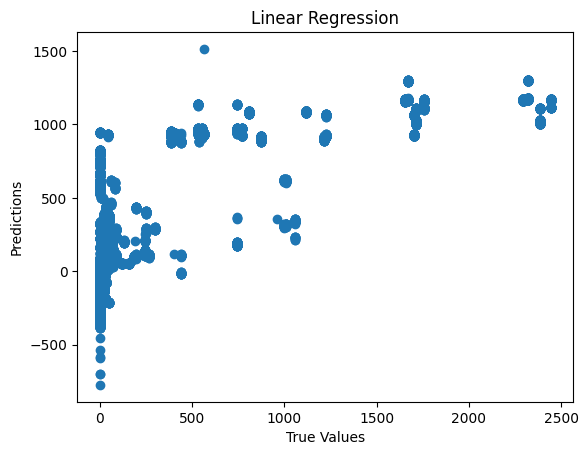

In [14]:
# visualizing the results
plot_predictions(y_test, lr_y_pred, 'Linear Regression')

In [15]:
# dataframe with the predictions and the actual values, plus other metrics
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_y_pred})
lr_results['Difference'] = lr_results['Actual'] - lr_results['Predicted']
lr_results['Absolute Difference'] = np.abs(lr_results['Difference'])
lr_results['Squared Difference'] = lr_results['Difference'] ** 2

lr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
103837,4.9900,47.087301,-42.097301,42.097301,1.772183e+03
89650,2319.9900,1170.363848,1149.626152,1149.626152,1.321640e+06
47723,0.0000,-114.522907,114.522907,114.522907,1.311550e+04
81859,0.0000,808.696401,-808.696401,808.696401,6.539899e+05
102098,0.0000,-241.207585,241.207585,241.207585,5.818110e+04
...,...,...,...,...,...
56479,69.9900,98.296009,-28.306009,28.306009,8.012301e+02
83567,53.9900,36.357500,17.632500,17.632500,3.109051e+02
28095,0.0000,-289.394593,289.394593,289.394593,8.374923e+04
31710,14.9776,141.737700,-126.760100,126.760100,1.606812e+04


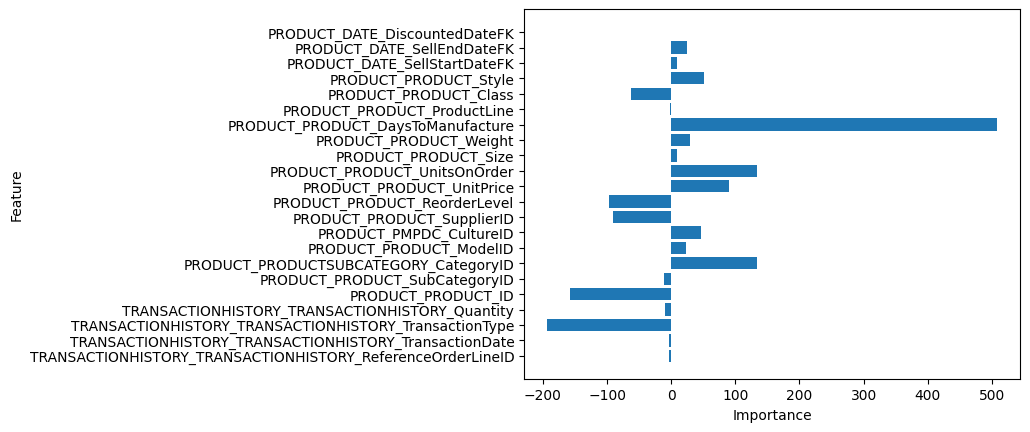

In [16]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, lr_model.coef_)

### Decision Tree

In [17]:
# fitting the model
dtr_model = DecisionTreeRegressor(max_depth=5)

dtr_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5)

In [18]:
# predicting the values
dtr_y_pred = dtr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the data

In [19]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 4206.8850411497615
R2 Score: 0.9863864761687774


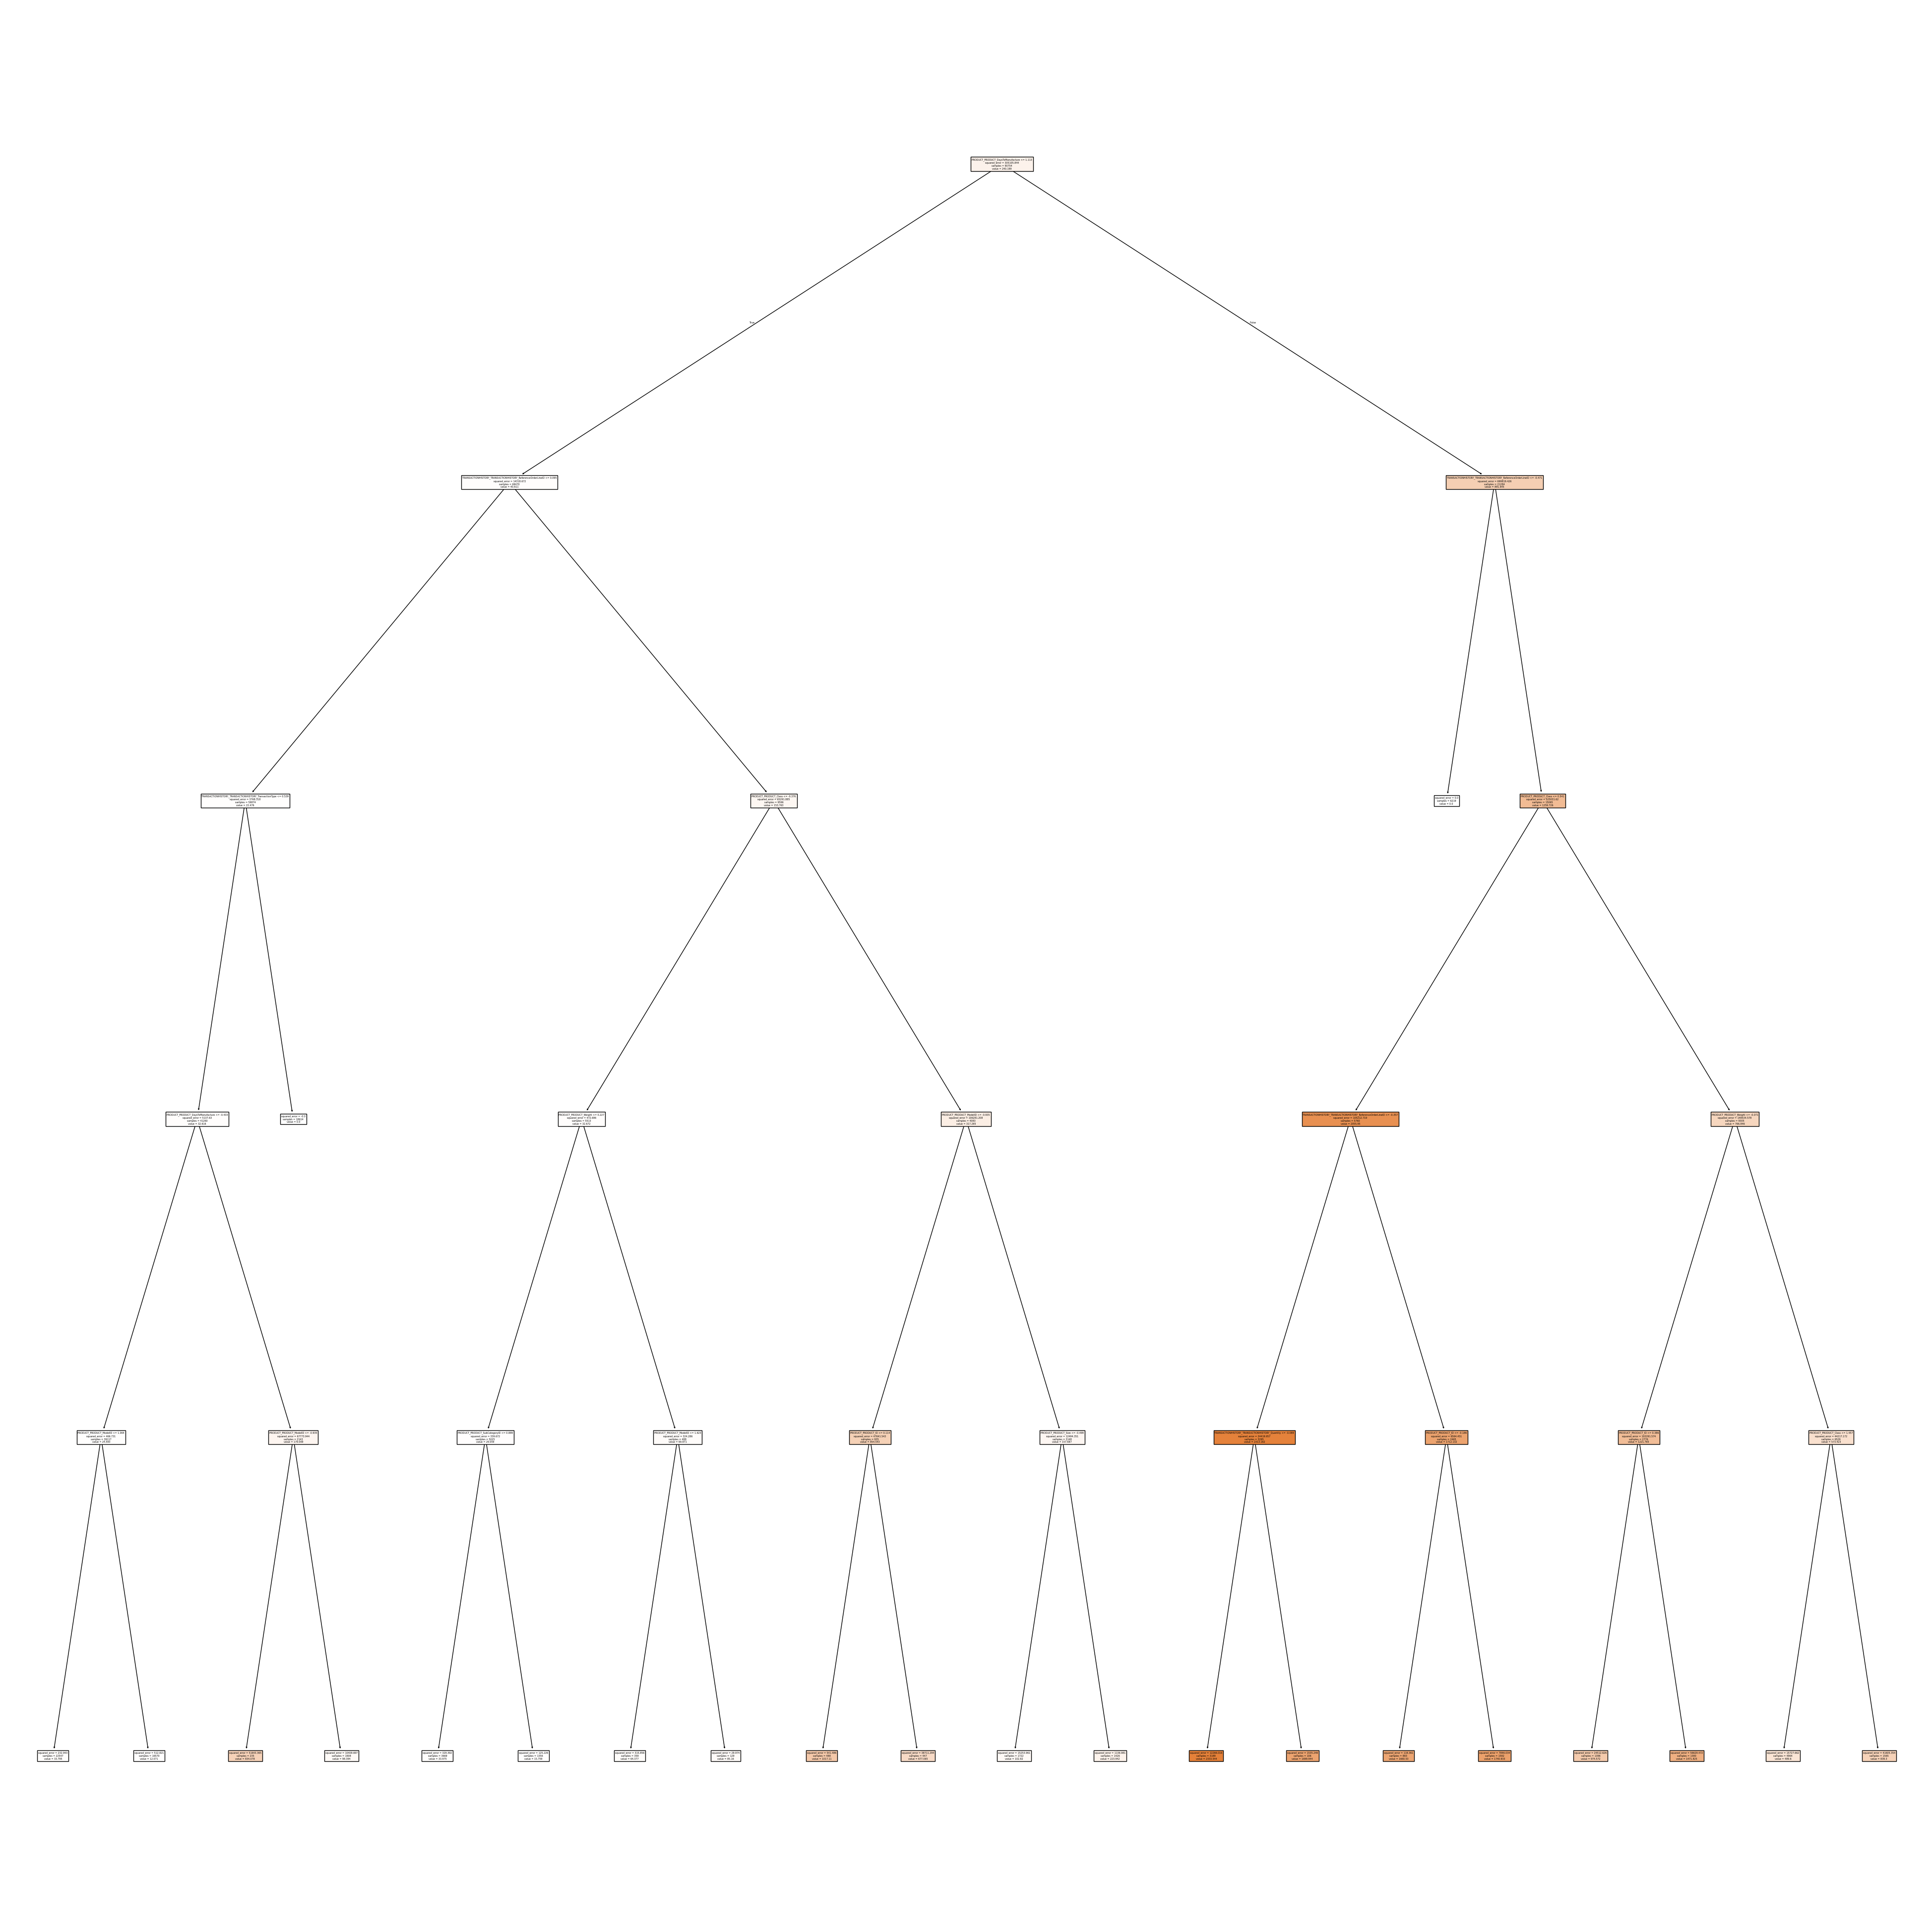

In [20]:
# visualizing the decision tree
plt.figure(figsize=(50, 50))
plot_tree(dtr_model, filled=True, feature_names=X.columns)
plt.show()

In [21]:
# dataframe with the predictions and the actual values, plus other metrics
dtr_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_y_pred})
dtr_results['Difference'] = dtr_results['Actual'] - dtr_results['Predicted']
dtr_results['Absolute Difference'] = np.abs(dtr_results['Difference'])
dtr_results['Squared Difference'] = dtr_results['Difference'] ** 2

dtr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
103837,4.9900,12.070928,-7.080928,7.080928,50.139548
89650,2319.9900,2333.544450,-13.554450,13.554450,183.723113
47723,0.0000,0.000000,0.000000,0.000000,0.000000
81859,0.0000,0.000000,0.000000,0.000000,0.000000
102098,0.0000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
56479,69.9900,33.795167,36.194833,36.194833,1310.065929
83567,53.9900,33.795167,20.194833,20.194833,407.831276
28095,0.0000,0.000000,0.000000,0.000000,0.000000
31710,14.9776,33.974529,-18.996929,18.996929,360.883318


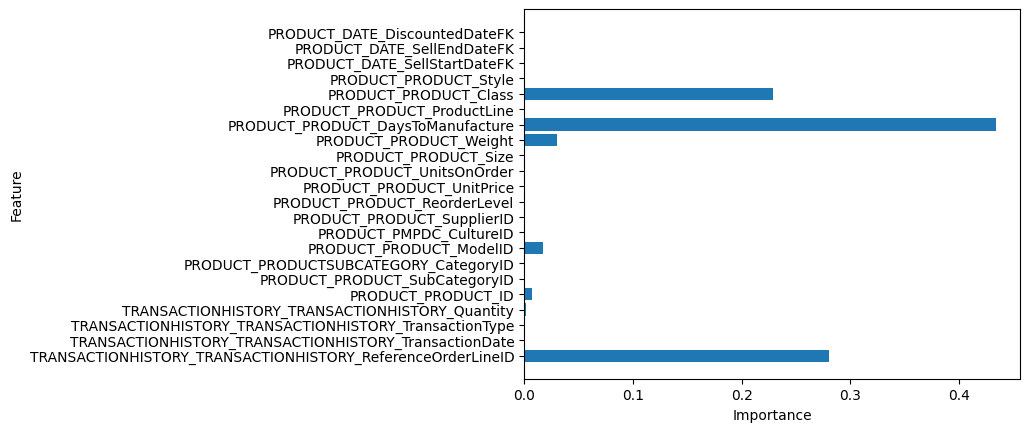

In [22]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, dtr_model.feature_importances_)

### Random Forest

In [23]:
# fitting the model
rfr_model = RandomForestRegressor(n_estimators=500)

rfr_model.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=500)

In [24]:
# predicting the values
rfr_y_pred = rfr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the data

In [25]:
# calculating the metrics
rfr_mse = mean_squared_error(y_test, rfr_y_pred)
rfr_r2 = r2_score(y_test, rfr_y_pred)
print(f'Mean Squared Error: {rfr_mse}')
print(f'R2 Score: {rfr_r2}')

Mean Squared Error: 591.6967774012156
R2 Score: 0.998085263062523


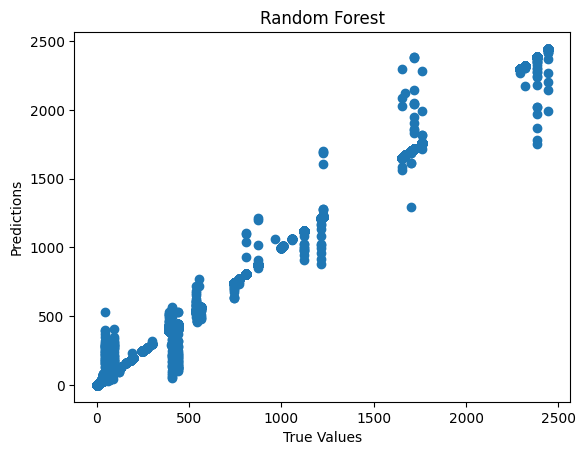

In [26]:
# plotting the results
plot_predictions(y_test, rfr_y_pred, 'Random Forest')

In [27]:
# dataframe with the predictions and the actual values, plus other metrics
rfr_results = pd.DataFrame({'Actual': y_test, 'Predicted': rfr_y_pred})
rfr_results['Difference'] = rfr_results['Actual'] - rfr_results['Predicted']
rfr_results['Absolute Difference'] = np.abs(rfr_results['Difference'])
rfr_results['Squared Difference'] = rfr_results['Difference'] ** 2

rfr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
103837,4.9900,4.9900,3.286260e-14,3.286260e-14,1.079951e-27
89650,2319.9900,2319.9900,8.640200e-12,8.640200e-12,7.465305e-23
47723,0.0000,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
81859,0.0000,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
102098,0.0000,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...
56479,69.9900,69.9900,-5.400125e-13,5.400125e-13,2.916135e-25
83567,53.9900,53.9900,-5.684342e-13,5.684342e-13,3.231174e-25
28095,0.0000,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
31710,14.9776,14.9776,-1.136868e-13,1.136868e-13,1.292470e-26


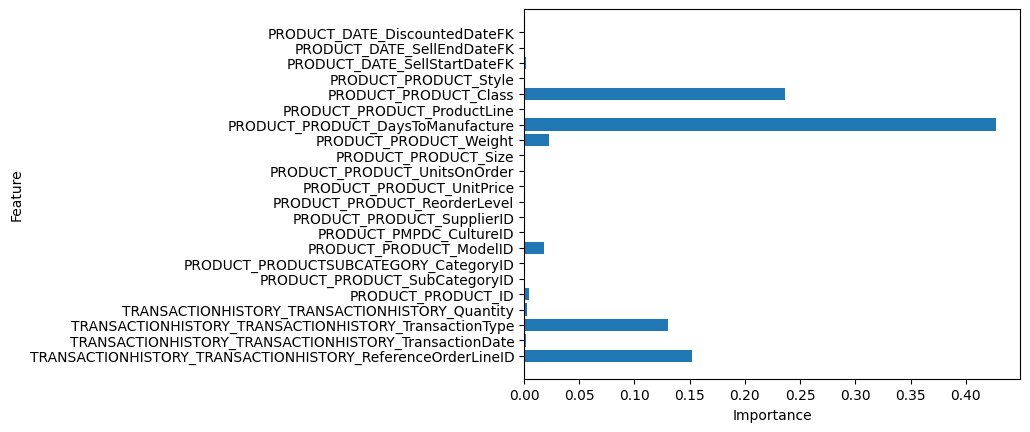

In [28]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, rfr_model.feature_importances_)

### Gradient Boosting

In [29]:
# fitting the model
gbr_model = GradientBoostingRegressor(n_estimators=500)

gbr_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(n_estimators=500)

In [30]:
# predicting the values
gbr_y_pred = gbr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the data

In [31]:
# calculating the metrics
gbr_mse = mean_squared_error(y_test, gbr_y_pred)
gbr_r2 = r2_score(y_test, gbr_y_pred)
print(f'Mean Squared Error: {gbr_mse}')
print(f'R2 Score: {gbr_r2}')

Mean Squared Error: 1661.448628247468
R2 Score: 0.9946235349257803


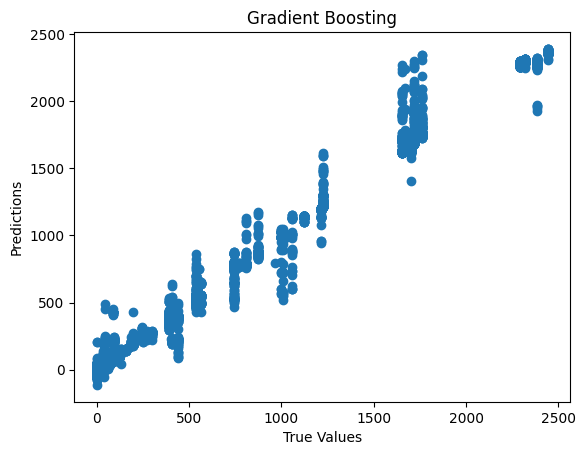

In [32]:
# plotting the results
plot_predictions(y_test, gbr_y_pred, 'Gradient Boosting')

In [33]:
# dataframe with the predictions and the actual values, plus other metrics
gbr_results = pd.DataFrame({'Actual': y_test, 'Predicted': gbr_y_pred})
gbr_results['Difference'] = gbr_results['Actual'] - gbr_results['Predicted']
gbr_results['Absolute Difference'] = np.abs(gbr_results['Difference'])
gbr_results['Squared Difference'] = gbr_results['Difference'] ** 2

gbr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
103837,4.9900,5.452140,-0.462140,0.462140,0.213573
89650,2319.9900,2303.118064,16.871936,16.871936,284.662218
47723,0.0000,-9.187773,9.187773,9.187773,84.415168
81859,0.0000,32.648723,-32.648723,32.648723,1065.939096
102098,0.0000,-3.684732,3.684732,3.684732,13.577248
...,...,...,...,...,...
56479,69.9900,75.339174,-5.349174,5.349174,28.613663
83567,53.9900,54.967244,-0.977244,0.977244,0.955005
28095,0.0000,-10.286318,10.286318,10.286318,105.808345
31710,14.9776,5.775715,9.201885,9.201885,84.674696


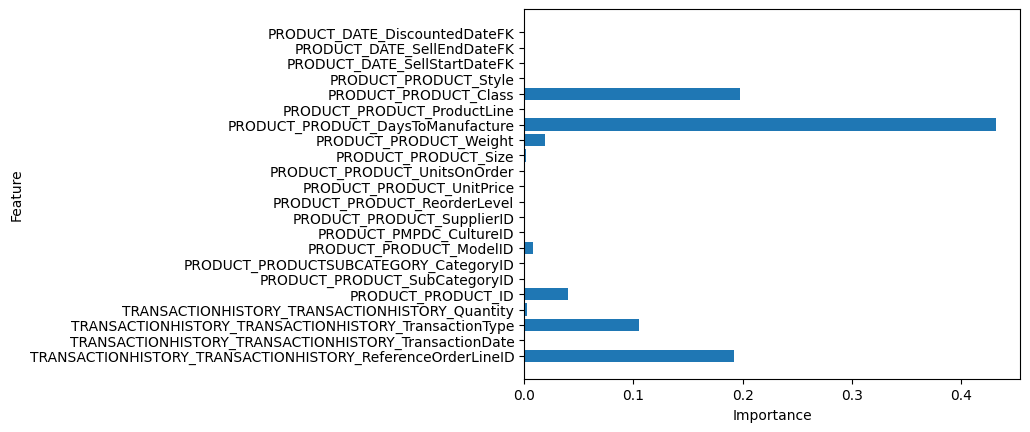

In [34]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, gbr_model.feature_importances_)

### Neural Network

In [35]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# converting the scaled data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)  # target variable often doesn't need scaling
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Using device: cuda


In [36]:
# instantiate the model
p_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_tensor.shape[1], 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
).to(device)

# define the loss function and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.01)

# Create TensorDatasets for training and test data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and test data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Train the model
train_model(p_model, criterion, optimizer, train_loader, num_epochs=200)

Epoch 0, Loss: 73.00601196289062


KeyboardInterrupt: 

#### Calculating the metrics and visualizing the data

In [ ]:
# Evaluate the model
p_model.eval()
p_mse_list = []
p_r2_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = p_model(inputs)
        mse = mean_squared_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        p_mse_list.append(mse)
        p_r2_list.append(r2)

# Calculate the average metrics
p_avg_mse = np.mean(p_mse_list)
p_avg_r2 = np.mean(p_r2_list)

print(f'Average Mean Squared Error: {p_avg_mse}')
print(f'Average R2 Score: {p_avg_r2}')

In [ ]:
# dataframe with the predictions and the actual values, plus other metrics
p_results = pd.DataFrame({'Actual': y_test_tensor.cpu().detach().numpy(), 'Predicted': p_model(X_test_tensor).cpu().detach().numpy().flatten()})
p_results['Difference'] = p_results['Actual'] - p_results['Predicted']
p_results['Absolute Difference'] = np.abs(p_results['Difference'])
p_results['Squared Difference'] = p_results['Difference'] ** 2

p_results

In [ ]:
# plotting the results
plot_predictions(y_test_tensor.cpu().detach().numpy(), p_model(X_test_tensor).cpu().detach().numpy().flatten(), 'Pytorch Network')